## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1024258103906739759
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2897023024330637793
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13769416686281449224
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 144506880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18112130488624951706
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

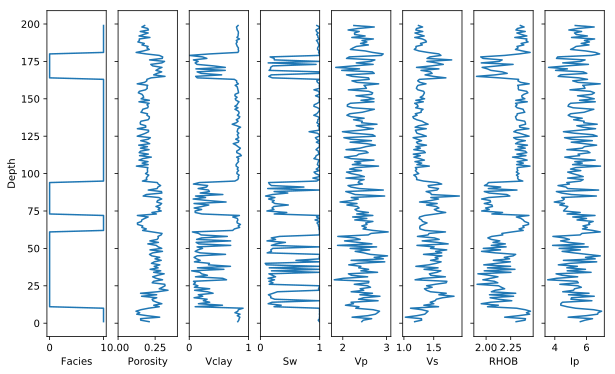

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

Text(0.5,0,'Vp/Vs')

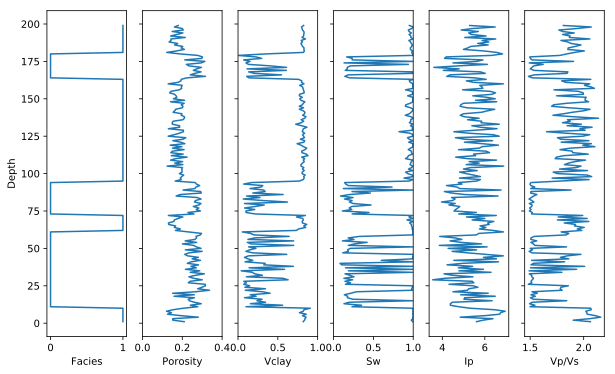

In [6]:
sample_number = 12
f, axarr = plt.subplots(1, 6, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[4].set_xlabel("Ip")

axarr[5].plot(Vp[sample_number, :]/Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vp/Vs")

In [7]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


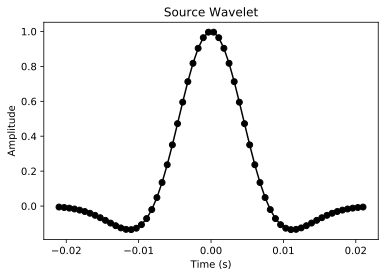

In [8]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [9]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

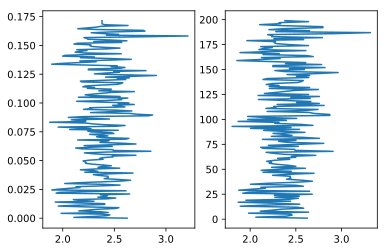

In [10]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


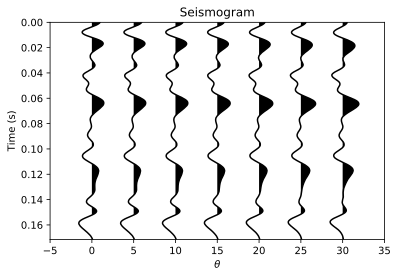

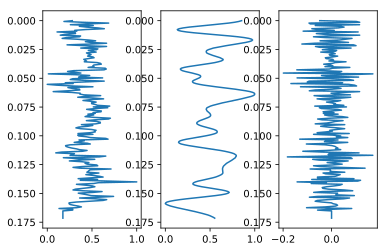

In [10]:
# Forward modeling results (Seismic gathers) (DONOT RUN IF NEW DATA IS NOT GENERATED)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [16]:
# Exporting generated seismic data
np.save('../../../Data_generation_base_case/seismic_forward_modeled.npy', seis)
np.save('../../../Data_generation_base_case/Rpp_forward_modeled.npy', Rpp)


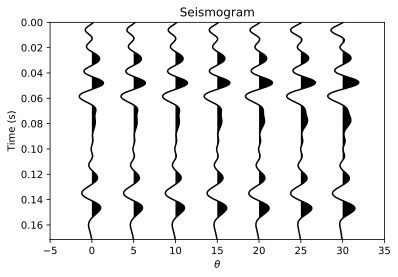

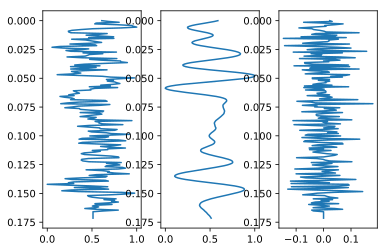

In [11]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [12]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [91]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Selecting near(0 degree), mid (15 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 3, 6])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Output as Ip, Vp_Vs ratio
num_examples = Vp_time.shape[0]

# # Normalize Vp, Vs and Density
# Vp_time_norm = (Vp_time - np.min(Vp_time))/(np.max(Vp_time) - np.min(Vp_time))
# Vs_time_norm = (Vs_time - np.min(Vs_time))/(np.max(Vs_time) - np.min(Vs_time))
# RHOB_time_norm = (RHOB_time - np.min(RHOB_time))/(np.max(RHOB_time) - np.min(RHOB_time))

emodel = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time), axis=1)
# emodel = np.concatenate((Vp_time_norm,Vs_time_norm,RHOB_time_norm), axis=1)
emodel = emodel.reshape((num_examples, 2, nt))


# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
#                                                                             emodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
# print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 3, 246, 1)
Y_train shape: (2000, 2, 246)
X_test shape: (500, 3, 246, 1)
Y_test shape: (500, 2, 246)


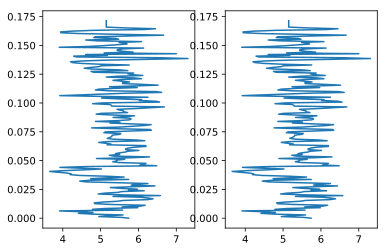

In [15]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

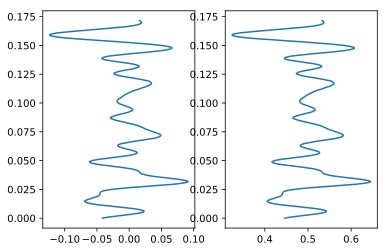

In [16]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [92]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (1, 60), strides=(1, 1), name='conv0', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 60), strides=(1, 1), name='conv1', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(200, name='fc0',
#              kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
#     X = Activation('relu')(X)
    X = Dense(246*2, name='fc1',
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
    X = Reshape((2, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [93]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


In [94]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 3, 246, 60)        3660      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 3, 246, 60)        240       
_________________________________________________________________
activation_16 (Activation)   (None, 3, 246, 60)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 3, 246, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 246, 1)         3601      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3, 246, 1)         4         
__________

In [80]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 500.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [95]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [96]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic.h5")

In [97]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250)
mc = ModelCheckpoint('best_model_elastic.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [98]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)


Epoch 00001: val_loss improved from inf to 3.19705, saving model to best_model_elastic.h5

Epoch 00002: val_loss did not improve from 3.19705

Epoch 00003: val_loss improved from 3.19705 to 0.63914, saving model to best_model_elastic.h5

Epoch 00004: val_loss improved from 0.63914 to 0.45278, saving model to best_model_elastic.h5

Epoch 00005: val_loss improved from 0.45278 to 0.43328, saving model to best_model_elastic.h5

Epoch 00006: val_loss did not improve from 0.43328

Epoch 00007: val_loss did not improve from 0.43328

Epoch 00008: val_loss did not improve from 0.43328

Epoch 00009: val_loss did not improve from 0.43328

Epoch 00010: val_loss did not improve from 0.43328

Epoch 00011: val_loss did not improve from 0.43328

Epoch 00012: val_loss did not improve from 0.43328

Epoch 00013: val_loss did not improve from 0.43328

Epoch 00014: val_loss improved from 0.43328 to 0.42084, saving model to best_model_elastic.h5

Epoch 00015: val_loss did not improve from 0.42084

Epoch 00


Epoch 00141: val_loss did not improve from 0.14741

Epoch 00142: val_loss did not improve from 0.14741

Epoch 00143: val_loss did not improve from 0.14741

Epoch 00144: val_loss did not improve from 0.14741

Epoch 00145: val_loss did not improve from 0.14741

Epoch 00146: val_loss did not improve from 0.14741

Epoch 00147: val_loss did not improve from 0.14741

Epoch 00148: val_loss did not improve from 0.14741

Epoch 00149: val_loss did not improve from 0.14741

Epoch 00150: val_loss did not improve from 0.14741

Epoch 00151: val_loss improved from 0.14741 to 0.14581, saving model to best_model_elastic.h5

Epoch 00152: val_loss did not improve from 0.14581

Epoch 00153: val_loss did not improve from 0.14581

Epoch 00154: val_loss did not improve from 0.14581

Epoch 00155: val_loss did not improve from 0.14581

Epoch 00156: val_loss did not improve from 0.14581

Epoch 00157: val_loss did not improve from 0.14581

Epoch 00158: val_loss did not improve from 0.14581

Epoch 00159: val_los


Epoch 00293: val_loss did not improve from 0.14101

Epoch 00294: val_loss did not improve from 0.14101

Epoch 00295: val_loss improved from 0.14101 to 0.14045, saving model to best_model_elastic.h5

Epoch 00296: val_loss did not improve from 0.14045

Epoch 00297: val_loss did not improve from 0.14045

Epoch 00298: val_loss did not improve from 0.14045

Epoch 00299: val_loss did not improve from 0.14045

Epoch 00300: val_loss did not improve from 0.14045

Epoch 00301: val_loss did not improve from 0.14045

Epoch 00302: val_loss did not improve from 0.14045

Epoch 00303: val_loss improved from 0.14045 to 0.13903, saving model to best_model_elastic.h5

Epoch 00304: val_loss did not improve from 0.13903

Epoch 00305: val_loss did not improve from 0.13903

Epoch 00306: val_loss did not improve from 0.13903

Epoch 00307: val_loss did not improve from 0.13903

Epoch 00308: val_loss did not improve from 0.13903

Epoch 00309: val_loss did not improve from 0.13903

Epoch 00310: val_loss did not


Epoch 00446: val_loss did not improve from 0.13728

Epoch 00447: val_loss did not improve from 0.13728

Epoch 00448: val_loss did not improve from 0.13728

Epoch 00449: val_loss did not improve from 0.13728

Epoch 00450: val_loss did not improve from 0.13728

Epoch 00451: val_loss did not improve from 0.13728

Epoch 00452: val_loss did not improve from 0.13728

Epoch 00453: val_loss did not improve from 0.13728

Epoch 00454: val_loss did not improve from 0.13728

Epoch 00455: val_loss did not improve from 0.13728

Epoch 00456: val_loss did not improve from 0.13728

Epoch 00457: val_loss did not improve from 0.13728

Epoch 00458: val_loss did not improve from 0.13728

Epoch 00459: val_loss did not improve from 0.13728

Epoch 00460: val_loss did not improve from 0.13728

Epoch 00461: val_loss did not improve from 0.13728

Epoch 00462: val_loss did not improve from 0.13728

Epoch 00463: val_loss did not improve from 0.13728

Epoch 00464: val_loss did not improve from 0.13728

Epoch 00465


Epoch 00599: val_loss did not improve from 0.13443

Epoch 00600: val_loss did not improve from 0.13443

Epoch 00601: val_loss did not improve from 0.13443

Epoch 00602: val_loss did not improve from 0.13443

Epoch 00603: val_loss did not improve from 0.13443

Epoch 00604: val_loss did not improve from 0.13443

Epoch 00605: val_loss did not improve from 0.13443

Epoch 00606: val_loss did not improve from 0.13443

Epoch 00607: val_loss did not improve from 0.13443

Epoch 00608: val_loss did not improve from 0.13443

Epoch 00609: val_loss did not improve from 0.13443

Epoch 00610: val_loss did not improve from 0.13443

Epoch 00611: val_loss did not improve from 0.13443

Epoch 00612: val_loss did not improve from 0.13443

Epoch 00613: val_loss did not improve from 0.13443

Epoch 00614: val_loss did not improve from 0.13443

Epoch 00615: val_loss did not improve from 0.13443

Epoch 00616: val_loss did not improve from 0.13443

Epoch 00617: val_loss did not improve from 0.13443

Epoch 00618


Epoch 00754: val_loss did not improve from 0.13090

Epoch 00755: val_loss did not improve from 0.13090

Epoch 00756: val_loss did not improve from 0.13090

Epoch 00757: val_loss did not improve from 0.13090

Epoch 00758: val_loss did not improve from 0.13090

Epoch 00759: val_loss did not improve from 0.13090

Epoch 00760: val_loss did not improve from 0.13090

Epoch 00761: val_loss did not improve from 0.13090

Epoch 00762: val_loss did not improve from 0.13090

Epoch 00763: val_loss did not improve from 0.13090

Epoch 00764: val_loss did not improve from 0.13090

Epoch 00765: val_loss did not improve from 0.13090

Epoch 00766: val_loss did not improve from 0.13090

Epoch 00767: val_loss did not improve from 0.13090

Epoch 00768: val_loss did not improve from 0.13090

Epoch 00769: val_loss did not improve from 0.13090

Epoch 00770: val_loss did not improve from 0.13090

Epoch 00771: val_loss did not improve from 0.13090

Epoch 00772: val_loss did not improve from 0.13090

Epoch 00773


Epoch 00908: val_loss did not improve from 0.12540

Epoch 00909: val_loss did not improve from 0.12540

Epoch 00910: val_loss did not improve from 0.12540

Epoch 00911: val_loss did not improve from 0.12540

Epoch 00912: val_loss did not improve from 0.12540

Epoch 00913: val_loss did not improve from 0.12540

Epoch 00914: val_loss did not improve from 0.12540

Epoch 00915: val_loss did not improve from 0.12540

Epoch 00916: val_loss did not improve from 0.12540

Epoch 00917: val_loss did not improve from 0.12540

Epoch 00918: val_loss did not improve from 0.12540

Epoch 00919: val_loss did not improve from 0.12540

Epoch 00920: val_loss did not improve from 0.12540

Epoch 00921: val_loss did not improve from 0.12540

Epoch 00922: val_loss did not improve from 0.12540

Epoch 00923: val_loss did not improve from 0.12540

Epoch 00924: val_loss did not improve from 0.12540

Epoch 00925: val_loss did not improve from 0.12540

Epoch 00926: val_loss did not improve from 0.12540

Epoch 00927


Epoch 01063: val_loss did not improve from 0.11775

Epoch 01064: val_loss improved from 0.11775 to 0.11371, saving model to best_model_elastic.h5

Epoch 01065: val_loss did not improve from 0.11371

Epoch 01066: val_loss did not improve from 0.11371

Epoch 01067: val_loss did not improve from 0.11371

Epoch 01068: val_loss did not improve from 0.11371

Epoch 01069: val_loss did not improve from 0.11371

Epoch 01070: val_loss did not improve from 0.11371

Epoch 01071: val_loss did not improve from 0.11371

Epoch 01072: val_loss did not improve from 0.11371

Epoch 01073: val_loss did not improve from 0.11371

Epoch 01074: val_loss did not improve from 0.11371

Epoch 01075: val_loss did not improve from 0.11371

Epoch 01076: val_loss did not improve from 0.11371

Epoch 01077: val_loss did not improve from 0.11371

Epoch 01078: val_loss did not improve from 0.11371

Epoch 01079: val_loss did not improve from 0.11371

Epoch 01080: val_loss did not improve from 0.11371

Epoch 01081: val_los


Epoch 01216: val_loss did not improve from 0.10648

Epoch 01217: val_loss did not improve from 0.10648

Epoch 01218: val_loss did not improve from 0.10648

Epoch 01219: val_loss did not improve from 0.10648

Epoch 01220: val_loss did not improve from 0.10648

Epoch 01221: val_loss did not improve from 0.10648

Epoch 01222: val_loss did not improve from 0.10648

Epoch 01223: val_loss did not improve from 0.10648

Epoch 01224: val_loss did not improve from 0.10648

Epoch 01225: val_loss did not improve from 0.10648

Epoch 01226: val_loss did not improve from 0.10648

Epoch 01227: val_loss did not improve from 0.10648

Epoch 01228: val_loss did not improve from 0.10648

Epoch 01229: val_loss did not improve from 0.10648

Epoch 01230: val_loss did not improve from 0.10648

Epoch 01231: val_loss did not improve from 0.10648

Epoch 01232: val_loss did not improve from 0.10648

Epoch 01233: val_loss did not improve from 0.10648

Epoch 01234: val_loss did not improve from 0.10648

Epoch 01235


Epoch 01373: val_loss did not improve from 0.10199

Epoch 01374: val_loss did not improve from 0.10199

Epoch 01375: val_loss did not improve from 0.10199

Epoch 01376: val_loss did not improve from 0.10199

Epoch 01377: val_loss did not improve from 0.10199

Epoch 01378: val_loss did not improve from 0.10199

Epoch 01379: val_loss did not improve from 0.10199

Epoch 01380: val_loss did not improve from 0.10199

Epoch 01381: val_loss did not improve from 0.10199

Epoch 01382: val_loss did not improve from 0.10199

Epoch 01383: val_loss did not improve from 0.10199

Epoch 01384: val_loss did not improve from 0.10199

Epoch 01385: val_loss did not improve from 0.10199

Epoch 01386: val_loss did not improve from 0.10199

Epoch 01387: val_loss did not improve from 0.10199

Epoch 01388: val_loss did not improve from 0.10199

Epoch 01389: val_loss did not improve from 0.10199

Epoch 01390: val_loss did not improve from 0.10199

Epoch 01391: val_loss did not improve from 0.10199

Epoch 01392

In [99]:
# load the saved model
ElasticModel = load_model('best_model_elastic.h5')

In [100]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.10011121898889541


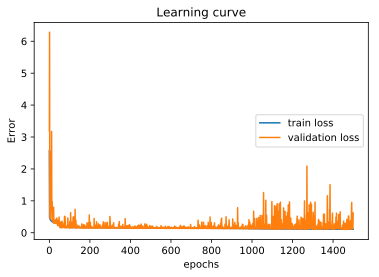

In [115]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['loss']/np.max(history.history['loss']))
# plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [23]:
# Save trained model 
# serialize model to JSON
model_json = ElasticModel.to_json()
with open("elastic_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticModel.save_weights("ElasticModel.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# Load saved model
# load json and create model
json_file = open('elastic_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

Loaded model from disk


In [143]:
# Predict training and test data using the trained network (if normalized output)
test_output_norm = ElasticModel.predict(X_test)
train_output_norm = ElasticModel.predict(X_train)

# Initialization
train_output = np.zeros(train_output_norm.shape)
test_output = np.zeros(test_output_norm.shape)
Y_train = np.zeros(Y_train_norm.shape)
Y_test = np.zeros(Y_test_norm.shape)

# Back transforming Vp, Vs and RHOB to unnormalized values 
train_output[:,0,:] = train_output_norm[:,0,:]*(np.max(Vp_time) - np.min(Vp_time)) + np.min(Vp_time)
test_output[:,0,:] = test_output_norm[:,0,:]*(np.max(Vp_time) - np.min(Vp_time)) + np.min(Vp_time)

train_output[:,1,:] = train_output_norm[:,1,:]*(np.max(Vs_time) - np.min(Vs_time)) + np.min(Vs_time)
test_output[:,1,:] = test_output_norm[:,1,:]*(np.max(Vs_time) - np.min(Vs_time)) + np.min(Vs_time)

train_output[:,2,:] = train_output_norm[:,2,:]*(np.max(RHOB_time) - np.min(RHOB_time)) + np.min(RHOB_time)
test_output[:,2,:] = test_output_norm[:,2,:]*(np.max(RHOB_time) - np.min(RHOB_time)) + np.min(RHOB_time)

Y_train[:,0,:] = Y_train_norm[:,0,:]*(np.max(Vp_time) - np.min(Vp_time)) + np.min(Vp_time)
Y_test[:,0,:] = Y_test_norm[:,0,:]*(np.max(Vp_time) - np.min(Vp_time)) + np.min(Vp_time)

Y_train[:,1,:] = Y_train_norm[:,1,:]*(np.max(Vs_time) - np.min(Vs_time)) + np.min(Vs_time)
Y_test[:,1,:] = Y_test_norm[:,1,:]*(np.max(Vs_time) - np.min(Vs_time)) + np.min(Vs_time)

Y_train[:,2,:] = Y_train_norm[:,2,:]*(np.max(RHOB_time) - np.min(RHOB_time)) + np.min(RHOB_time)
Y_test[:,2,:] = Y_test_norm[:,2,:]*(np.max(RHOB_time) - np.min(RHOB_time)) + np.min(RHOB_time)

In [102]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

Text(0,0.5,'Time')

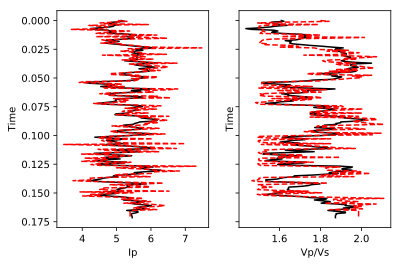

In [113]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Ip")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vp/Vs")
axarr[1].set_ylabel("Time")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

# axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(1, 2.5)

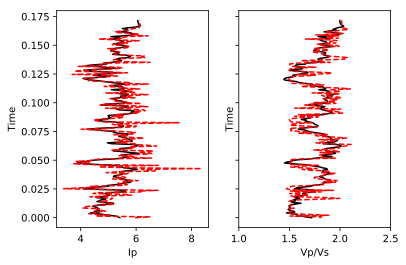

In [107]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Ip")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vp/Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1,2.5)

# axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [108]:
# Correlation coefficient between true and predicted traces 

Ip_corr_train = np.zeros(train_output.shape[0])
Vp_Vs_corr_train = np.zeros(train_output.shape[0])
# RHOB_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Ip_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vp_Vs_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     RHOB_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Ip_corr_test = np.zeros(test_output.shape[0])
Vp_Vs_corr_test = np.zeros(test_output.shape[0])
# RHOB_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Ip_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vp_Vs_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     RHOB_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in Ip for training data = ", np.mean(Ip_corr_train))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_train))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_train))

print("Average correlation in Ip for training data = ", np.mean(Ip_corr_test))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_test))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_test))

Average correlation in Ip for training data =  0.7963563097764581
Average correlation in Vp_Vs for training data =  0.7824845584881741
Average correlation in Ip for training data =  0.7695046795021205
Average correlation in Vp_Vs for training data =  0.7522676087793921


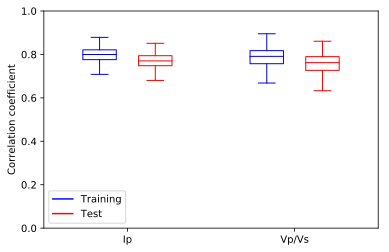

In [109]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

A= [Ip_corr_train, Ip_corr_test]
B = [Vp_Vs_corr_train, Vp_Vs_corr_test]
# C = [RHOB_corr_train, RHOB_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# # thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Vp', 'Vs', 'RHOB'])
ax.set_xticklabels(['Ip', 'Vp/Vs'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

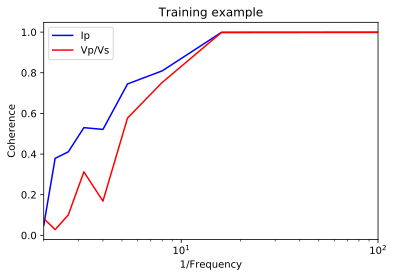

In [110]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_ip, wavenumber_ip = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue")
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red")
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

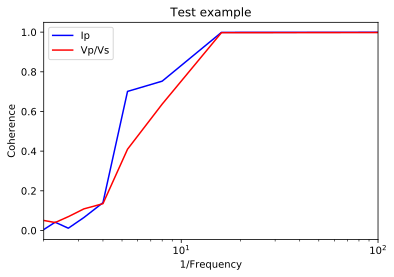

In [111]:
# Spectral coherence between true and predicted (training data)

sample_number = 12
Cxy_ip, wavenumber_ip = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_test[sample_number,2,:], test_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue")
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red")
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

## Predicting petrophysical properties from elastic properties of previous network

In [268]:
# Use predicted Ip, Vp/Vs from network
# Concatenate Ip, Vp/Vs

num_examples = Vp_time.shape[0]
emodel_true = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time,), axis=1)
emodel_true = emodel.reshape((num_examples, 2, nt))

# emodel_norm = ElasticModel.predict(np.expand_dims(seis_reshaped_normalized, axis=3))
emodel = ElasticModel.predict(np.expand_dims(angle_seis_reshaped_normalized, axis=3))


# Concatenate Porosity, Vclay
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))

# petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))

# Split data into train and test set - elastic model predicted
X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(emodel, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Split data into train and test set - elastic model true
X_train_true, X_test_true, Y_train_true_norm, Y_test_true_norm = sklearn.model_selection.train_test_split(emodel_true, 
                                                                            petromodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 2, 246, 1)
Y_train shape: (2000, 2, 199)
X_test shape: (500, 2, 246, 1)
Y_test shape: (500, 2, 199)


In [272]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility

def elastic_petronet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (1, 30), strides=(1, 2), name='conv0', padding='same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(4, (1, 30), strides=(1, 2), name='conv1', padding='same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*2, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((2, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticPetroModel')

    return model
    ### END CODE HERE ###

In [273]:
# Create the model
ElasticPetroModel = elastic_petronet(X_train.shape[1:])

In [274]:
# Summary and plot of the model

ElasticPetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 123, 16)        496       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 123, 16)        64        
_________________________________________________________________
activation_55 (Activation)   (None, 2, 123, 16)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 123, 16)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 62, 4)          1924      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 62, 4)          16        
__________

In [27]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [275]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [276]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic_petro.h5")

In [277]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_elastic_petro.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [278]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticPetroModel.fit(X_train, Y_train_norm, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)


Epoch 00001: val_loss improved from inf to 0.15353, saving model to best_model_elastic_petro.h5

Epoch 00002: val_loss did not improve from 0.15353

Epoch 00003: val_loss did not improve from 0.15353

Epoch 00004: val_loss did not improve from 0.15353

Epoch 00005: val_loss did not improve from 0.15353

Epoch 00006: val_loss improved from 0.15353 to 0.09466, saving model to best_model_elastic_petro.h5

Epoch 00007: val_loss did not improve from 0.09466

Epoch 00008: val_loss improved from 0.09466 to 0.05738, saving model to best_model_elastic_petro.h5

Epoch 00009: val_loss improved from 0.05738 to 0.05426, saving model to best_model_elastic_petro.h5

Epoch 00010: val_loss did not improve from 0.05426

Epoch 00011: val_loss improved from 0.05426 to 0.04439, saving model to best_model_elastic_petro.h5

Epoch 00012: val_loss improved from 0.04439 to 0.04407, saving model to best_model_elastic_petro.h5

Epoch 00013: val_loss did not improve from 0.04407

Epoch 00014: val_loss did not imp


Epoch 00141: val_loss did not improve from 0.03377

Epoch 00142: val_loss did not improve from 0.03377

Epoch 00143: val_loss did not improve from 0.03377

Epoch 00144: val_loss did not improve from 0.03377

Epoch 00145: val_loss did not improve from 0.03377

Epoch 00146: val_loss improved from 0.03377 to 0.03365, saving model to best_model_elastic_petro.h5

Epoch 00147: val_loss did not improve from 0.03365

Epoch 00148: val_loss did not improve from 0.03365

Epoch 00149: val_loss did not improve from 0.03365

Epoch 00150: val_loss did not improve from 0.03365

Epoch 00151: val_loss did not improve from 0.03365

Epoch 00152: val_loss did not improve from 0.03365

Epoch 00153: val_loss did not improve from 0.03365

Epoch 00154: val_loss did not improve from 0.03365

Epoch 00155: val_loss did not improve from 0.03365

Epoch 00156: val_loss did not improve from 0.03365

Epoch 00157: val_loss did not improve from 0.03365

Epoch 00158: val_loss did not improve from 0.03365

Epoch 00159: v


Epoch 00289: val_loss improved from 0.03330 to 0.03328, saving model to best_model_elastic_petro.h5

Epoch 00290: val_loss did not improve from 0.03328

Epoch 00291: val_loss did not improve from 0.03328

Epoch 00292: val_loss did not improve from 0.03328

Epoch 00293: val_loss did not improve from 0.03328

Epoch 00294: val_loss did not improve from 0.03328

Epoch 00295: val_loss did not improve from 0.03328

Epoch 00296: val_loss did not improve from 0.03328

Epoch 00297: val_loss did not improve from 0.03328

Epoch 00298: val_loss did not improve from 0.03328

Epoch 00299: val_loss did not improve from 0.03328

Epoch 00300: val_loss did not improve from 0.03328

Epoch 00301: val_loss did not improve from 0.03328

Epoch 00302: val_loss did not improve from 0.03328

Epoch 00303: val_loss improved from 0.03328 to 0.03325, saving model to best_model_elastic_petro.h5

Epoch 00304: val_loss did not improve from 0.03325

Epoch 00305: val_loss did not improve from 0.03325

Epoch 00306: val_

In [279]:
# load the saved model
ElasticPetroModel = load_model('best_model_elastic_petro.h5')

In [280]:
# Testing and evaluating the model
preds = ElasticPetroModel.evaluate(X_test, Y_test_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.03326635307073593


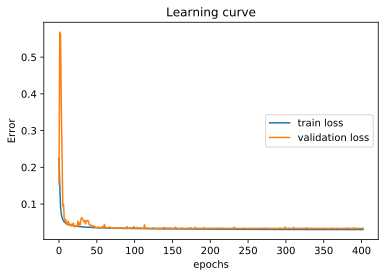

In [281]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['loss']/np.max(history.history['loss']))
# plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [ ]:
# Save trained model 
# serialize model to JSON
model_json = ElasticPetroModel.to_json()
with open("elastic_petromodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticPetroModel.save_weights("ElasticPetroModel.h5")
print("Saved model to disk")

In [ ]:
# Load saved model
# load json and create model
json_file = open('elastic_petromodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ElasticPetroModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticPetroModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [282]:
# Predict training and test data using the trained network
test_output_norm = ElasticPetroModel.predict(X_test)
train_output_norm = ElasticPetroModel.predict(X_train)

# Initialization
train_output = np.zeros(train_output_norm.shape)
test_output = np.zeros(test_output_norm.shape)
Y_train = np.zeros(Y_train_norm.shape)
Y_test = np.zeros(Y_test_norm.shape)

# Back transforming porosity to unnormalized values 
train_output[:,0,:] = train_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output[:,0,:] = test_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

train_output[:,1,:] = train_output_norm[:,1,:]
test_output[:,1,:] = test_output_norm[:,1,:]

Y_train[:,0,:] = Y_train_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test[:,0,:] = Y_test_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train[:,1,:] = Y_train_norm[:,1,:]
Y_test[:,1,:] = Y_test_norm[:,1,:]

In [164]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output - Y_train)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output - Y_test)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.16669661 0.29407367]
Test error =  [0.19362529 0.36330433]


Text(0,0.5,'Depth')

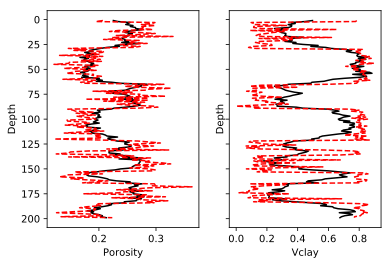

In [283]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

# axarr[2].plot(train_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

Text(0,0.5,'Depth')

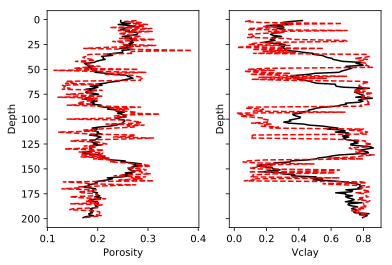

In [284]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

# axarr[2].plot(test_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [285]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output.shape[0])
Vclay_corr_train = np.zeros(train_output.shape[0])
# Sw_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output.shape[0])
Vclay_corr_test = np.zeros(test_output.shape[0])
# Sw_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))

Average correlation in porosity for training data =  0.7012743702540525
Average correlation in Vclay for training data =  0.7487747009017726
Average correlation in porosity for test data =  0.633103989045995
Average correlation in Vclay for test data =  0.6859002451064862


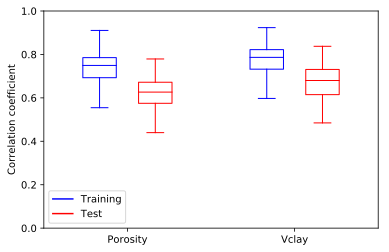

In [267]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

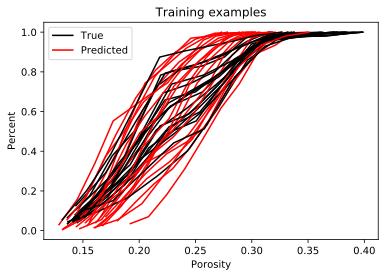

In [84]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
#     plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Training examples')

plt.legend(['True', 'Predicted'])




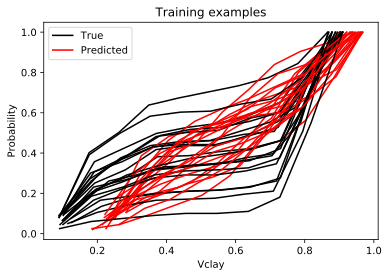

In [86]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Training examples')
    
plt.legend(['True', 'Predicted'])

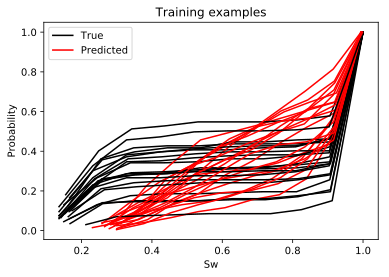

In [88]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Training examples')
plt.legend(['True', 'Predicted'])

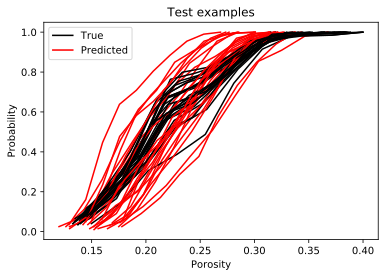

In [94]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Test examples')
plt.legend(['True', 'Predicted'])    

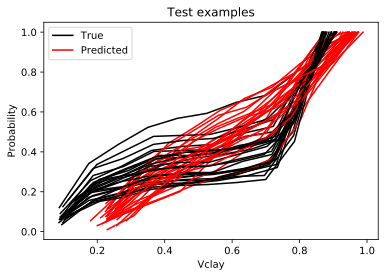

In [95]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

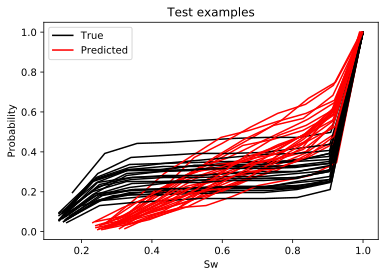

In [96]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

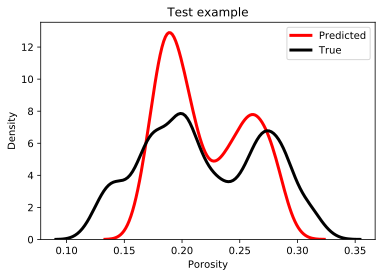

In [197]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output[sample_number,0,:],  
             color='red', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output[sample_number,0,:]), np.max(test_output[sample_number,0,:])))
sns.kdeplot(Y_test[sample_number,0,:],  
             color='black', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test[sample_number,0,:]), np.max(Y_test[sample_number,0,:])))
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

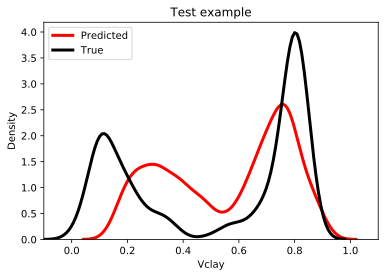

In [198]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output[sample_number,1,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,1,:]), np.max(test_output[sample_number,1,:])))
sns.kdeplot(Y_test[sample_number,1,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,1,:]), np.max(Y_test[sample_number,1,:])))
plt.xlabel('Vclay')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

(-0.1, 1.1)

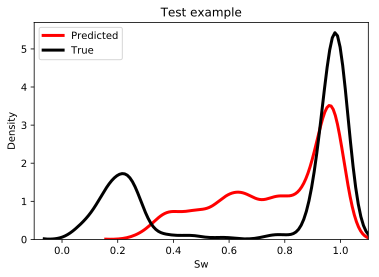

In [39]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,2,:]), np.max(test_output[sample_number,2,:])))
sns.kdeplot(Y_test[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,2,:]), np.max(Y_test[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

({'var': 0.0014618947278724529,
  'len_scale': 22.85758087305491,
  'nugget': 2.9665554724974387e-30},
 array([[ 7.63998901e-09, -5.91493483e-05, -6.96625235e-09],
        [-5.91493483e-05,  3.00209089e+00,  8.24202627e-05],
        [-6.96625235e-09,  8.24202627e-05,  7.18410059e-09]]))

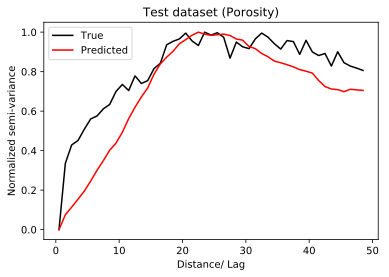

In [199]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.05635109804606979,
  'len_scale': 24.003373123368146,
  'nugget': 2.0991158694657967e-28},
 array([[ 1.20182175e-05, -2.45104662e-03, -1.08690694e-05],
        [-2.45104662e-03,  3.54804714e+00,  3.53237384e-03],
        [-1.08690694e-05,  3.53237384e-03,  1.12405845e-05]]))

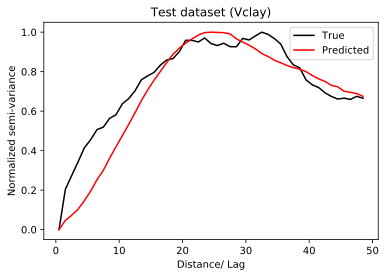

In [200]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

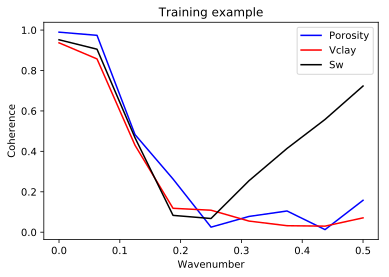

In [36]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

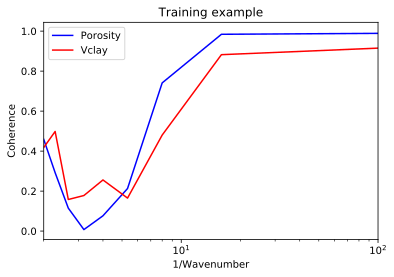

In [201]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_poro, wavenumber_poro = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

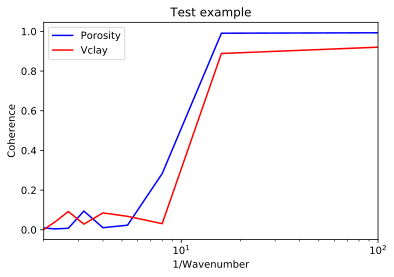

In [202]:
# Spectral coherence between true and predicted (test data)

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)